In [1]:
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.optimize import linprog
import matplotlib.pyplot as plt
import pickle
import random
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
%matplotlib inline
np.set_printoptions(edgeitems=100)
%load_ext autoreload
%autoreload
from smartcluster import get_lp, pulp_solve, plot_tree
%config InlineBackend.figure_format = 'retina'

In [2]:
with open('vectors.pkl', 'rb') as f:
    allvecs = pickle.load(f)

In [3]:
def sample_and_cluster(knn=200, n_samples=100):
    vec = random.choice(allvecs)
    vecs = allvecs[pd.Series(allvecs.dot(np.reshape(vec, -1, 1))).nlargest(200).index, :]
    vecs = vecs[random.sample(range(len(vecs)), 150), :]
    Z = linkage(vecs, optimal_ordering=True, metric='cosine', method='weighted')
    return Z

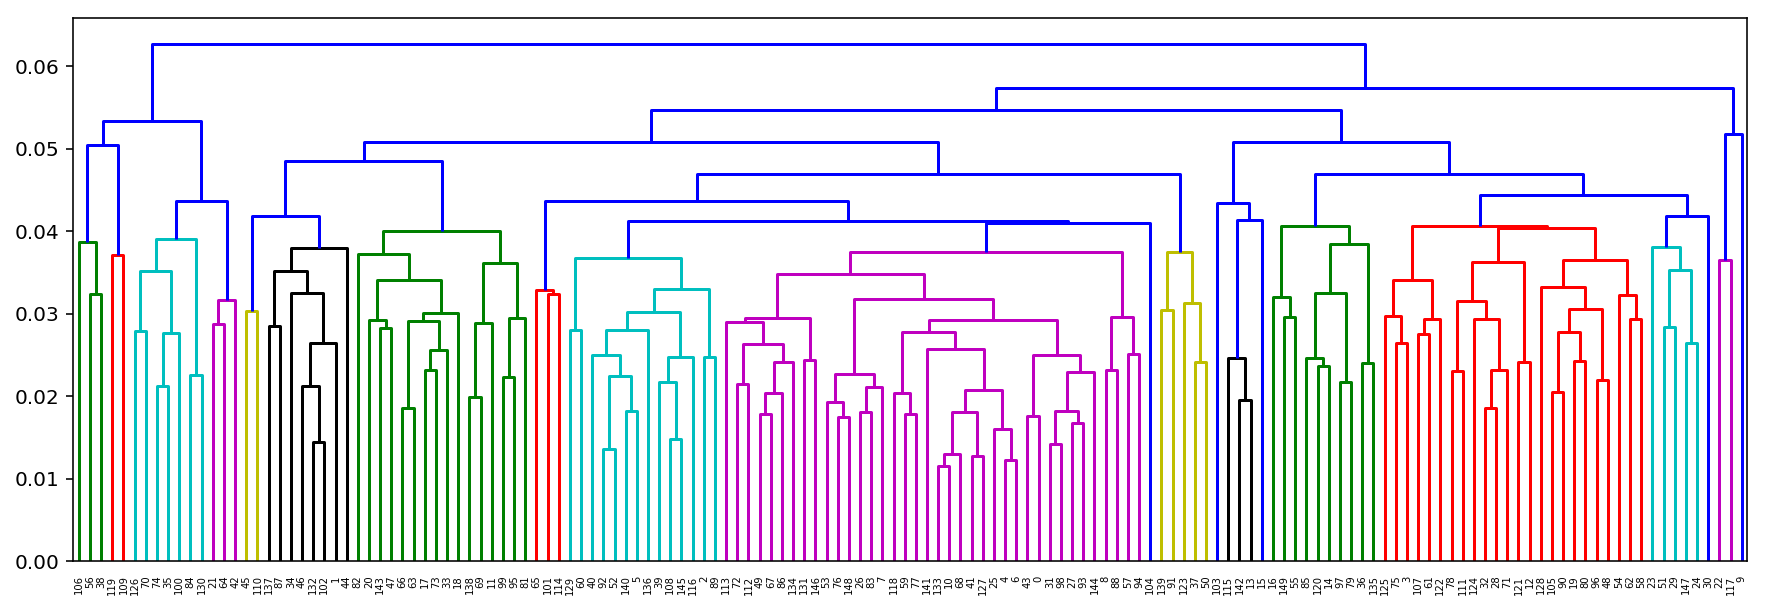

In [4]:
Z = sample_and_cluster()

fig, ax = plt.subplots(figsize=(15,5))
th = 0.65 * Z[:, 2].max()
dent = dendrogram(Z, truncate_mode='level', p=25, ax=ax, color_threshold=th)

## slow LP solver

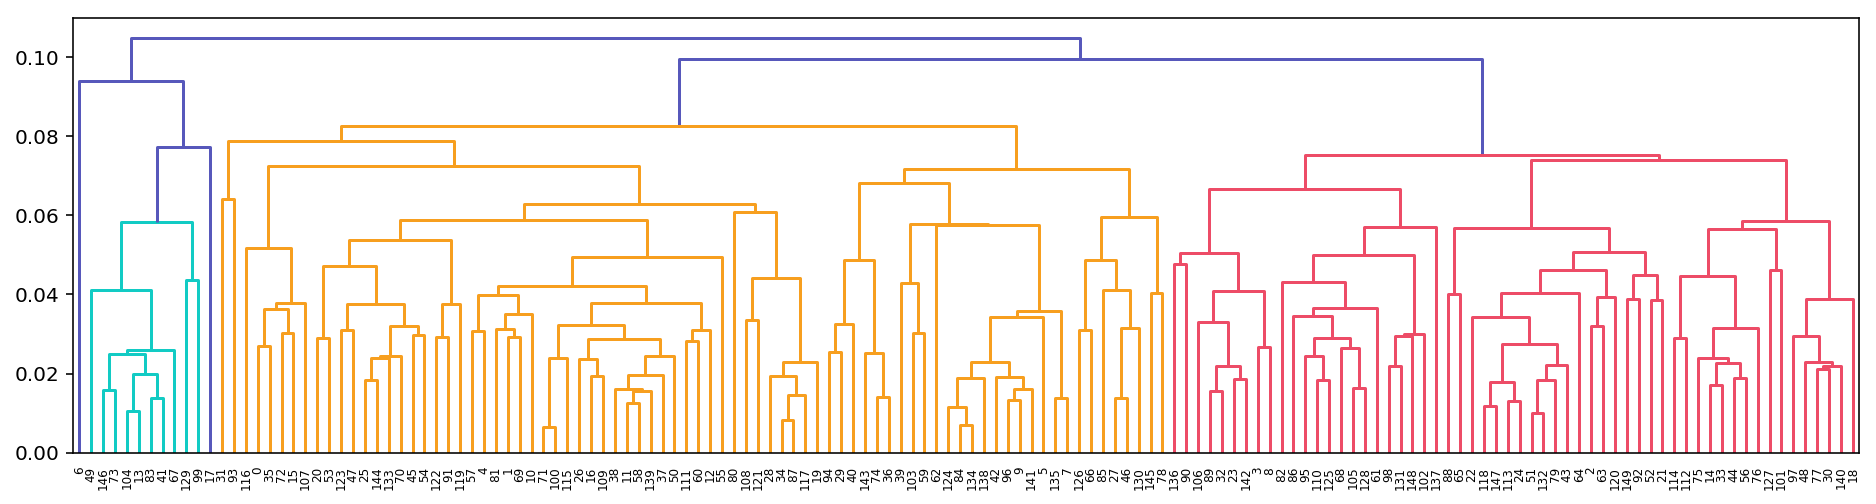

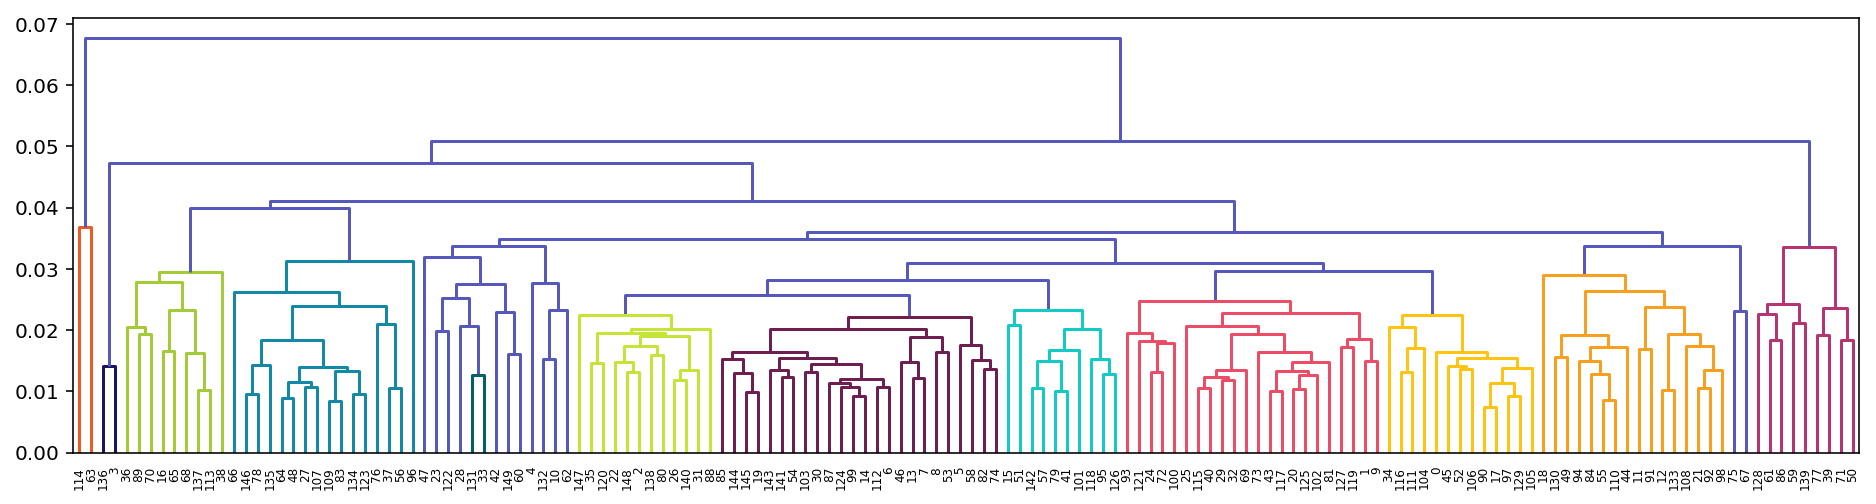

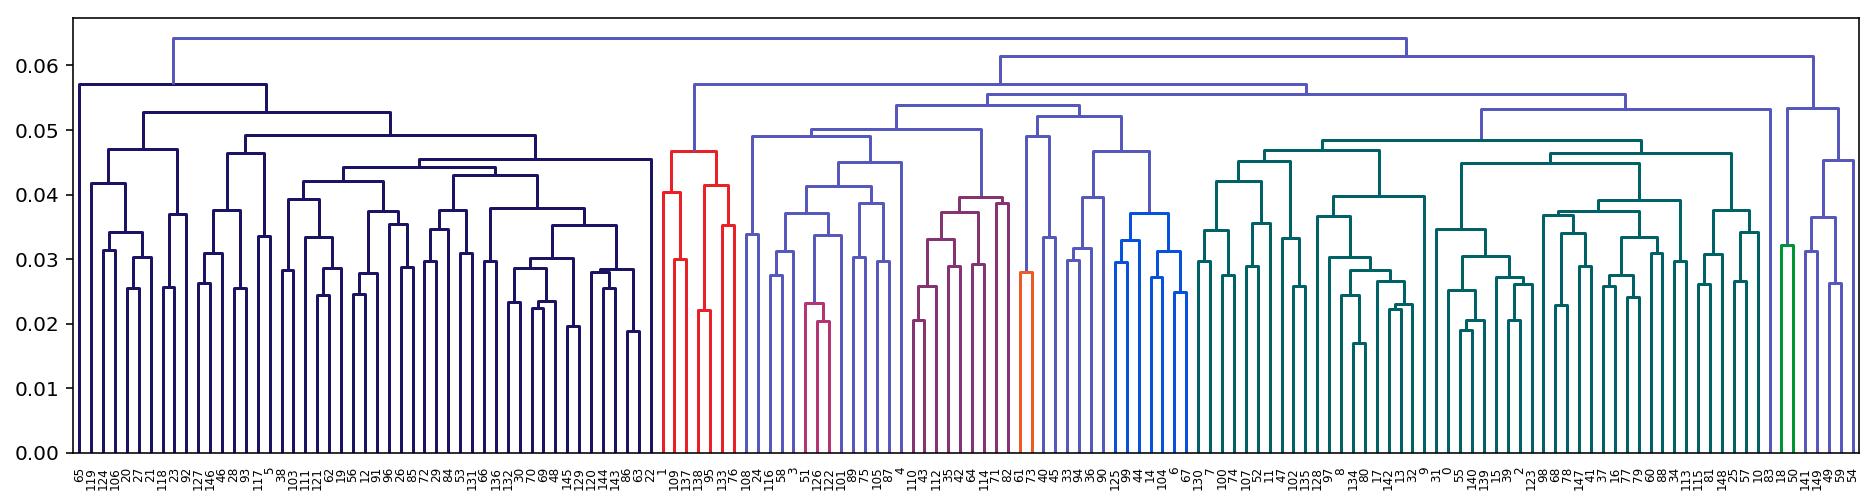

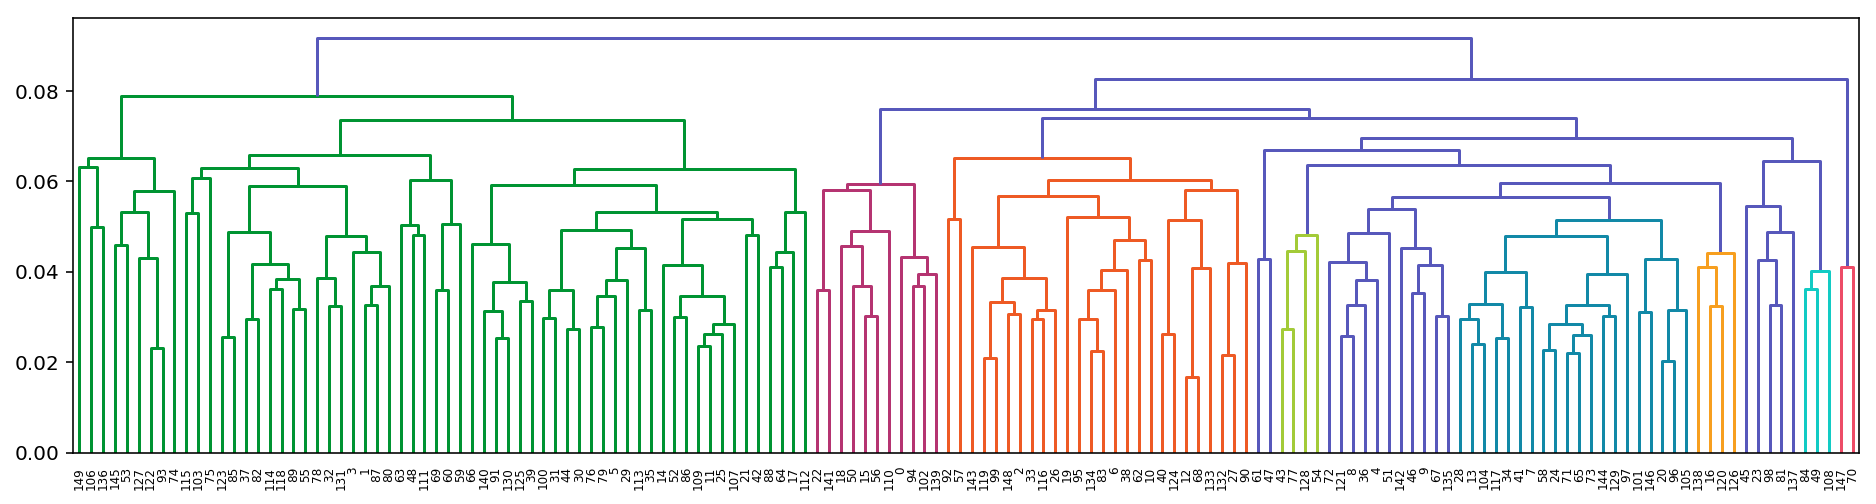

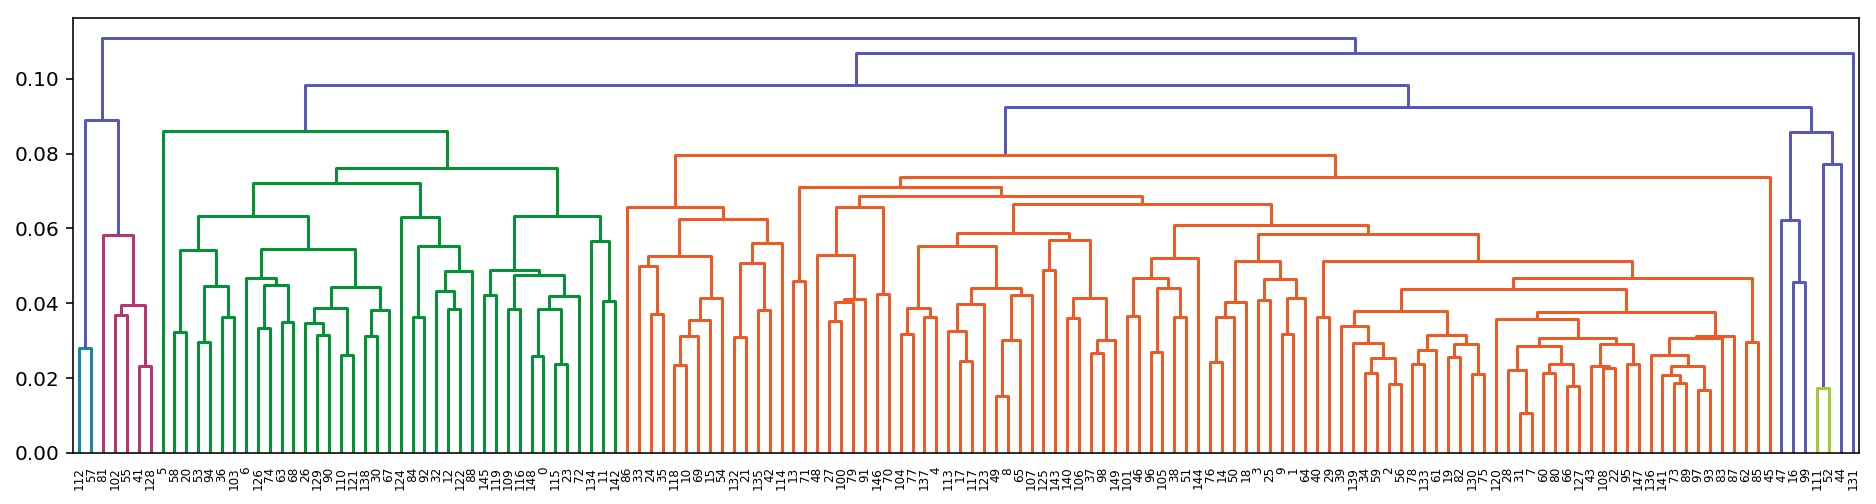

In [5]:
random.seed(43)

for _ in range(5):
    Z = sample_and_cluster(knn=150, n_samples=100)
    A, b, obj = get_lp(Z, stiffness=1.7)
    sol = pulp_solve(Z, A, b, obj)
    cluster_links = np.where(sol > 0)[0]
    fig, ax = plt.subplots(figsize=(16, 4))
    plot_tree(Z, cluster_links, 
              truncate_mode='level', p=20, ax=ax, leaf_font_size=6, leaf_rotation=90)

## fast explicit solver

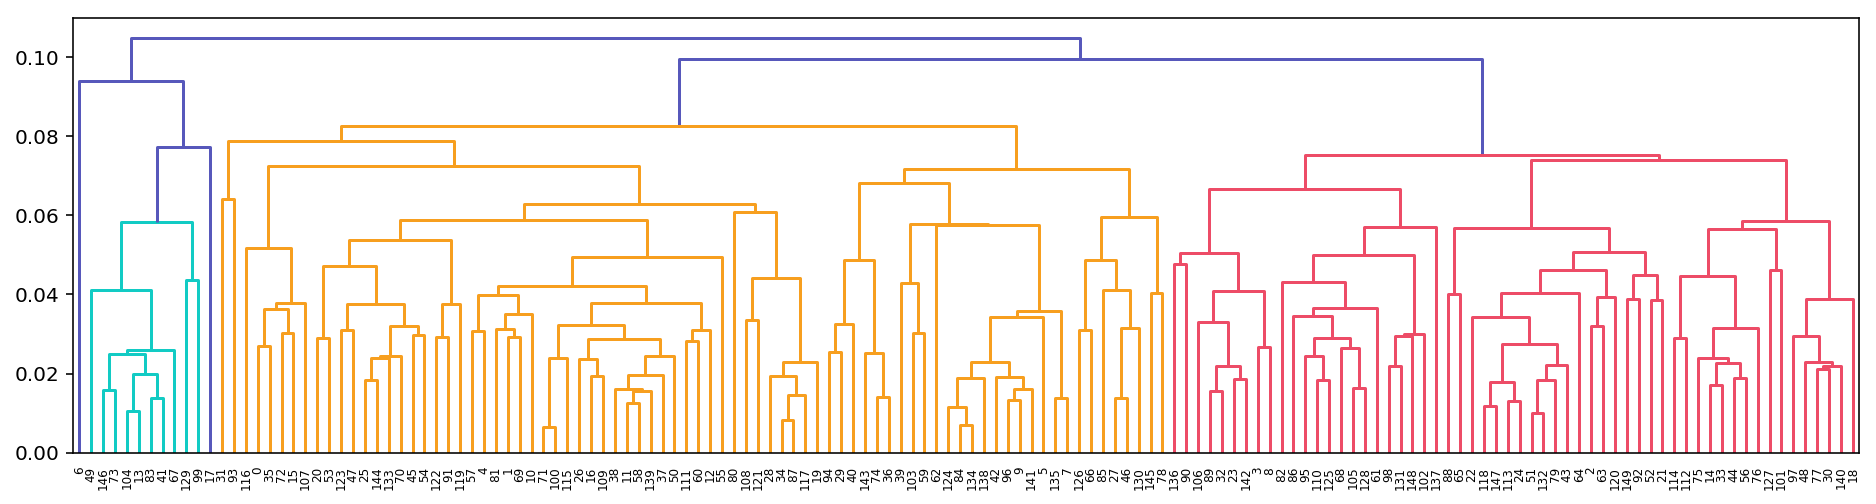

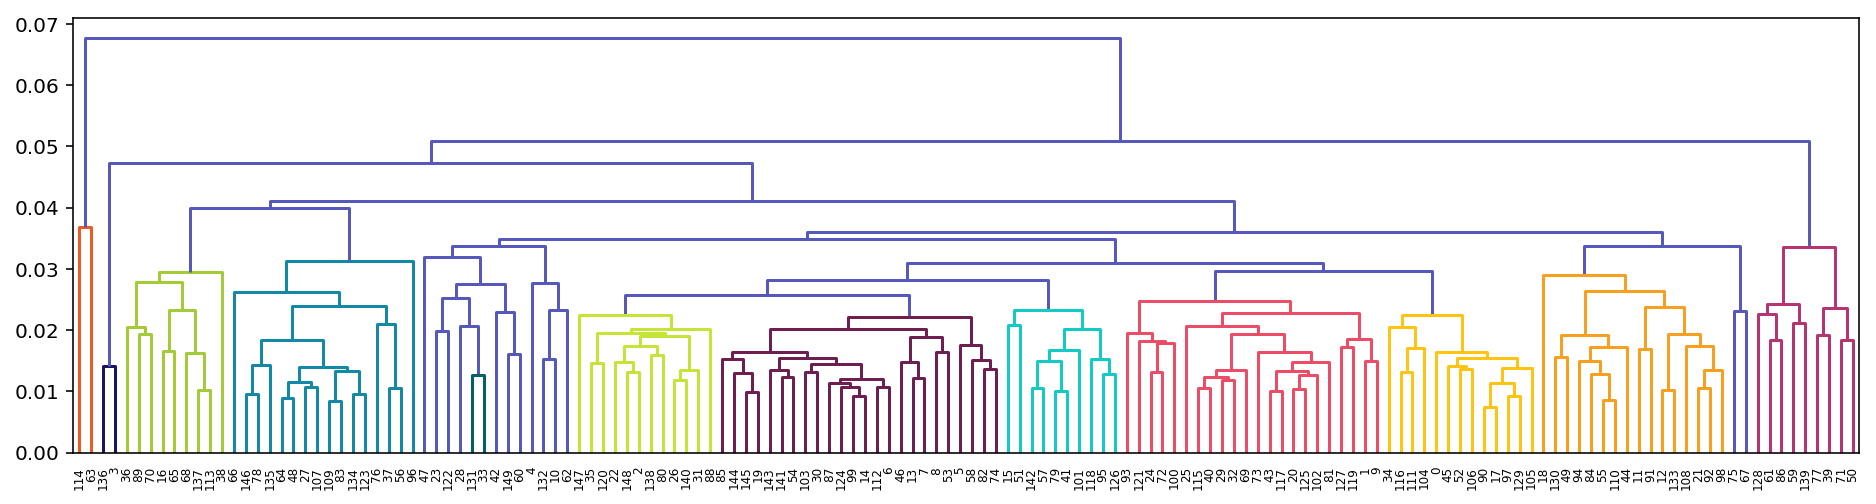

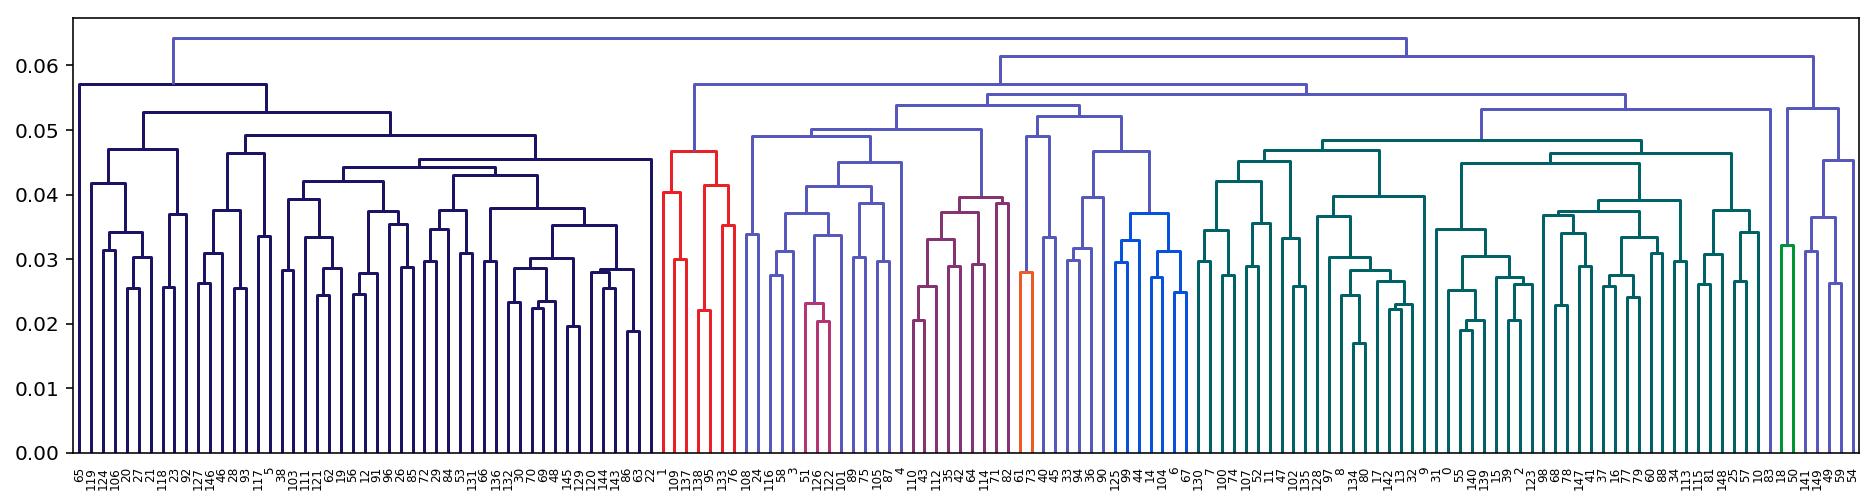

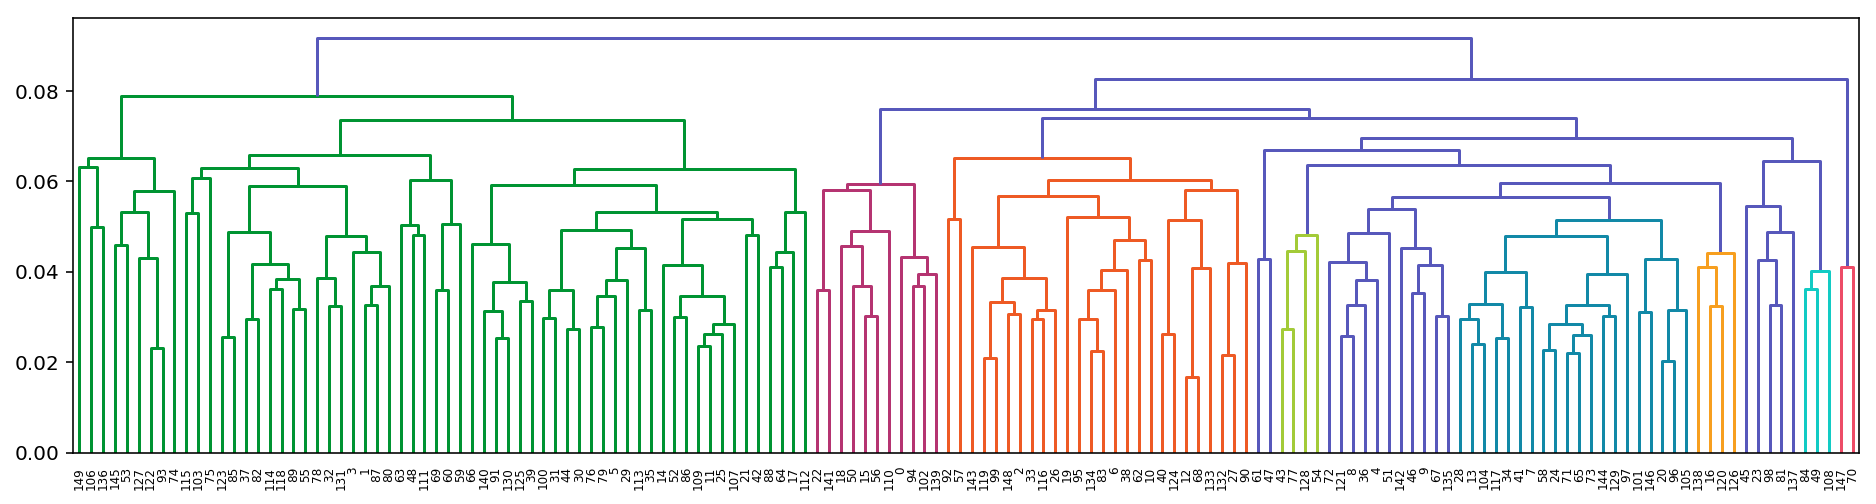

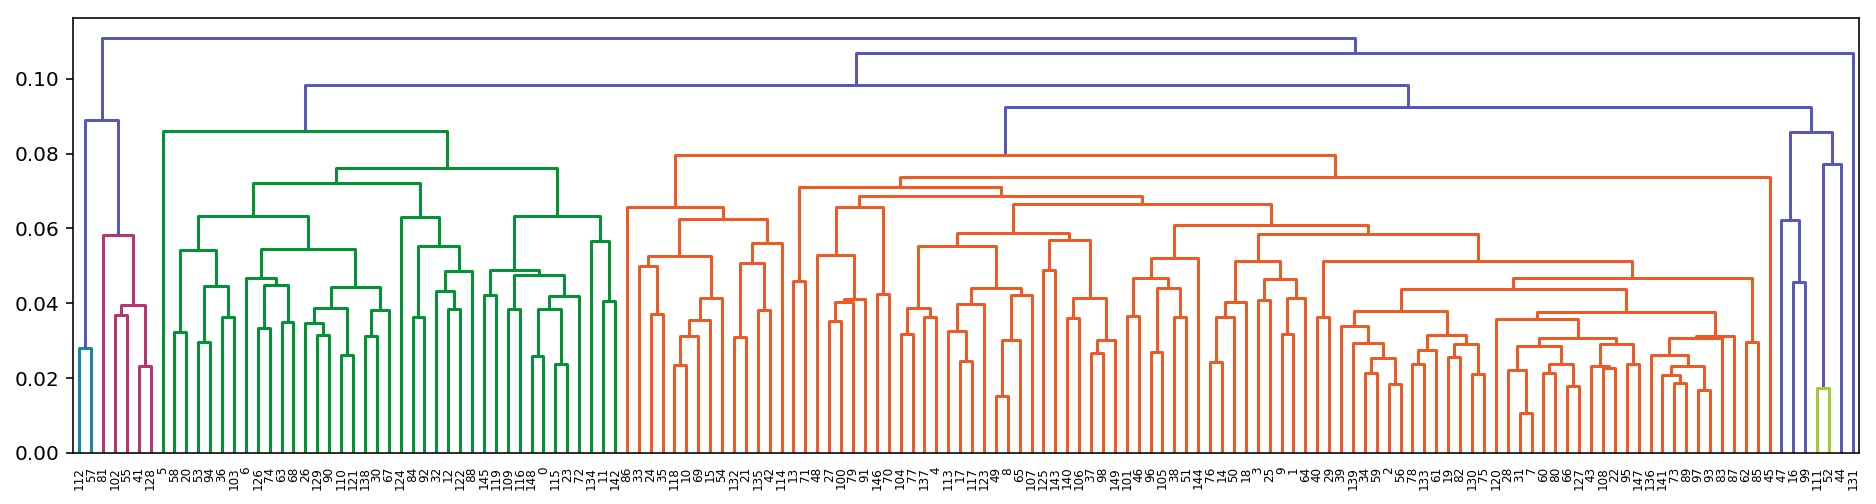

In [6]:
% autoreload
from smartcluster import flatten
random.seed(43)

for _ in range(5):
    Z = sample_and_cluster(knn=150, n_samples=100)
    id2cluster, score = flatten(Z, stiffness=1.7)
    cluster_links = sorted(set(id2cluster))
    fig, ax = plt.subplots(figsize=(16, 4))
    plot_tree(Z, cluster_links, 
              truncate_mode='level', p=20, ax=ax, leaf_font_size=6, leaf_rotation=90)

## Benchmark 

In [7]:
Z = sample_and_cluster(knn=300, n_samples=200)
A, b, obj = get_lp(Z, stiffness=1.7)
%timeit pulp_solve(Z, A, b, obj)
%timeit flatten(Z, stiffness=1.7)

98.9 ms ± 9.81 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.28 ms ± 58.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
